In [66]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from scipy.stats import expon
from utils import *


In [67]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    good_dict = {}

    for key in keys:

        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        # timeLimit = mergedConfigs["sim-time-limit"]

        
        # assert timeLimit.endswith('s'), "Time limit format is incorrect"
        # timeLimit = timeLimit[:-1]  # Remove the 's' at the end

        good_dict[measurement]={}
        good_dict[measurement]['measurement']=measurement
        good_dict[measurement]['parameters']=dict(item.split("=") for item in measurement.split(", "))
        good_dict[measurement]['repetition']=int(repetition)
        # good_dict[measurement]['timeLimit']=int(timeLimit)
        good_dict[measurement]['modules']={}

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in good_dict[measurement]['modules']:
                good_dict[measurement]['modules'][module] = {}

            good_dict[measurement]['modules'][module][name] = {}
            good_dict[measurement]['modules'][module][name]["times"] = a["time"]
            good_dict[measurement]['modules'][module][name]["values"] = a["value"]



    return good_dict


good_dict = importData("../multicore_sched/simulations/test.json")

In [68]:
#print keys of good_dict one under another
for key in good_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=200ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=200ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=200ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=200ms, $numCpus=12, $generationType="uniform", $durationType="uniform", $isFCFS=true
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=200ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=200ms, $numCpus=4, $generationType="uniform", $durationType="uniform", $isFCFS=true
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=200ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=2

In [69]:
filter={
    "$pCpuBound"                : None,
    "$rho"                      : None,
    "$meanProcessDuration"       : '200ms',
    "$numCpus"                  : None,
    "$generationType"           : '"exponential"',
    "$durationType"             : '"exponential"',
    "$isFCFS"                   : 'true'
}

In [70]:
rhoSmall='0.5'
rhoBig='0.8'

In [71]:
rhoStrings=[f"ρ = {rhoSmall}",f"ρ = {rhoBig}"]
colors1=['#1F77B4','#FF7F0E']
colors2=['#FF00FF','#FF0000']

In [72]:
filtered_dict={}
filtered_dict_rho={}
filtered_array_rho=[]


for key, value in good_dict.items():
    key_dict = dict(item.split("=") for item in key.split(", "))
    match = True
    for f_key, f_value in filter.items():
        if f_value is None:
            continue
        if key_dict.get(f_key) != f_value:
            break
    else:
        filtered_dict[key] = value

        rhoPos= not f'$rho={rhoSmall}' in key
        parametersNoRho = key_dict.copy()
        parametersNoRho.pop("$rho", None)
        parametersNoRhoString=str(parametersNoRho)

        if parametersNoRhoString not in filtered_dict_rho:
            filtered_dict_rho[parametersNoRhoString]=[{},{}]
        
        filtered_dict_rho[parametersNoRhoString][rhoPos] = value.copy()

#convert filtered_dict_rho to array
for key, value in filtered_dict_rho.items():
    filtered_array_rho.append(value)

# print(filtered_dict.keys())
for key in filtered_dict.keys():
    print(key)

$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=200ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.5, $meanProcessDuration=200ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=200ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.1, $rho=0.8, $meanProcessDuration=200ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=200ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.5, $meanProcessDuration=200ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.8, $meanProcessDuration=200ms, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=true
$pCpuBound=0.9, $rho=0.8

In [73]:
statistic='turnaroundTime:vector'

In [74]:
testToUse=list(filtered_dict.keys())[0]
values = filtered_dict[testToUse]['modules']["Computer.scheduler"][statistic]["values"]

In [75]:
def getMeasurement(axs,measurement):
    x=0
    y=0
    if "$numCpus=12" in measurement:
        x+=1
    if "$pCpuBound=0.9" in measurement:
        y=1

    # Format measurent = "$pCpuBound=0.1, $meanGenerationTime=30ms, $rho=0.4, $numCpus=4, $generationType="exponential", $durationType="exponential", $isFCFS=false"
    # to pCpuBound=0.1, numCpus=4
    parts = measurement.split(", ")

    pCpuBound = next(part for part in parts if "pCpuBound" in part)[1:]
    numCpus = next(part for part in parts if "numCpus" in part)[1:]

    measurementString = f"{pCpuBound}, {numCpus}"
    
    rhoVal = next(part for part in parts if "rho" in part).split("=")[1]

    rhoString = f"ρ = {rhoVal}"

    rhoNum=0
    color=''

    if rhoVal == rhoSmall:
        color = '#ff00ff'
        rhoNum=0
    else:
        color = '#ff0000'
        rhoNum=1

    
    return axs[x][y],measurementString

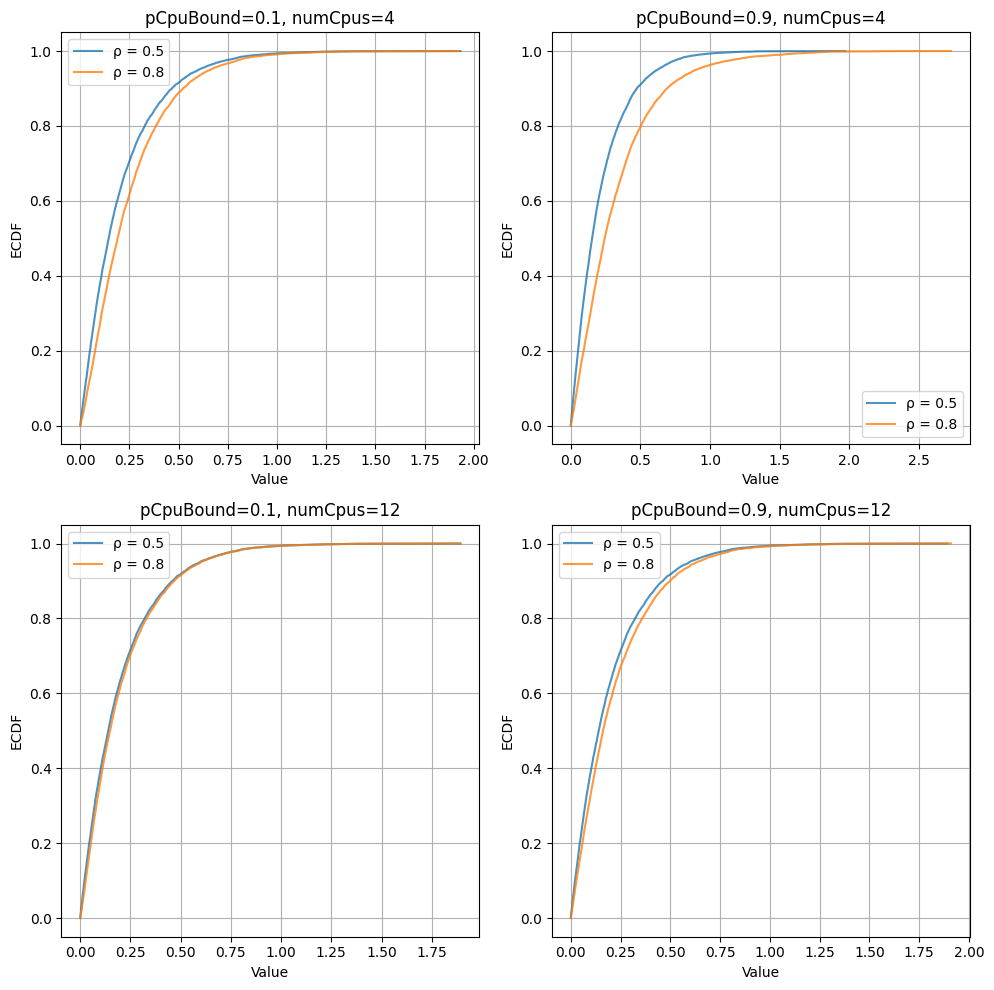

In [76]:
from statsmodels.distributions.empirical_distribution import ECDF

#for each element in filtered_array plt ecdf of statistic
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):

    for rhoNum, elementRho in enumerate(element):
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]

        ecdf = ECDF(values)
        ax,measurementString = getMeasurement(axs, measurement)
        ax.plot(ecdf.x, ecdf.y, label=rhoStrings[rhoNum],alpha=0.8,color=colors1[rhoNum])
        # ax.set_title(f"ECDF of {measurement}")
        ax.set_xlabel('Value')
        ax.set_ylabel('ECDF')
        ax.set_title(measurementString)
        ax.legend()
        ax.grid(True)
plt.tight_layout()
plt.show()

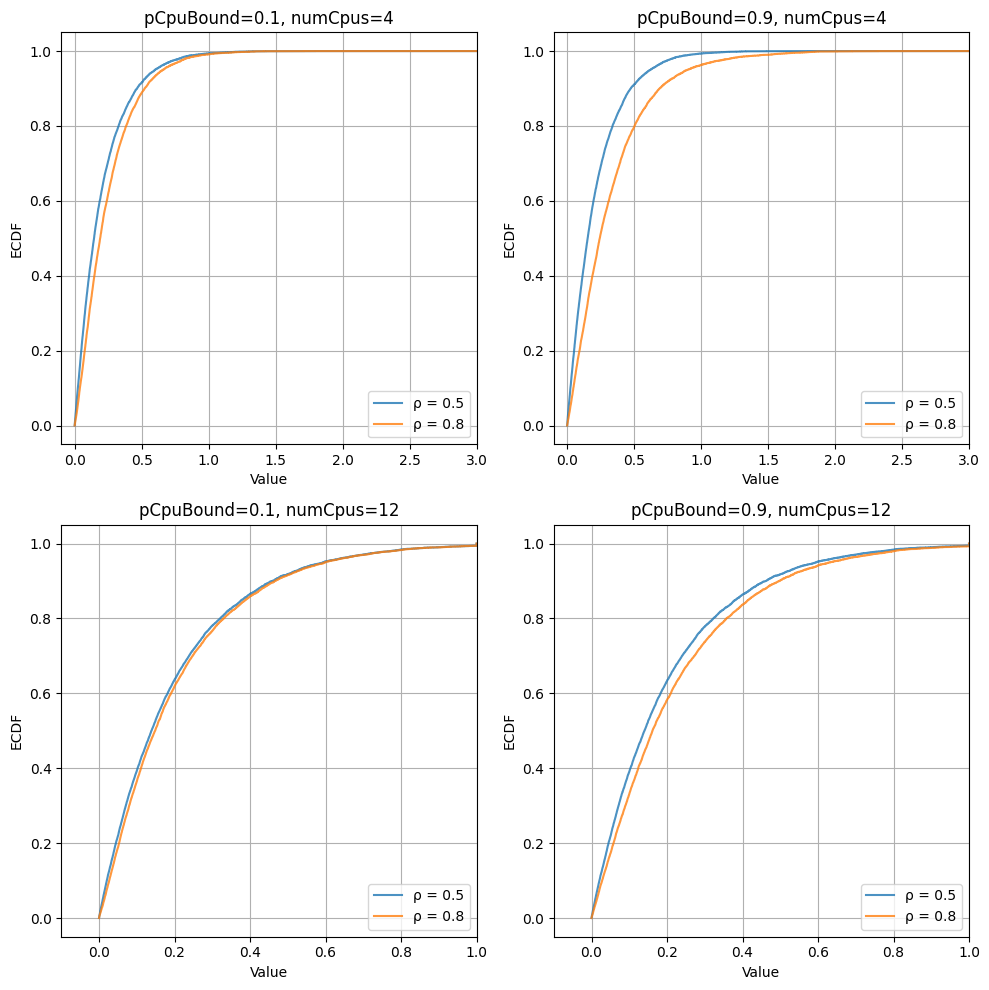

In [77]:
from statsmodels.distributions.empirical_distribution import ECDF

#for each element in filtered_array plt ecdf of statistic
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

maxXDict={}

xFin={
    '4':3,
    '12':1
}

for i, element in enumerate(filtered_array_rho):

    maxX=0
    
    for rhoNum, elementRho in enumerate(element):
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        ecdf = ECDF(values)

        # Extend ECDF to the right

        if ecdf.x[-1] > maxX:
            maxX = ecdf.x[-1]

        x=xFin[elementRho['parameters']['$numCpus']]

        x_extended = np.append(ecdf.x,x)
        y_extended = np.append(ecdf.y,1)

        ax,measurementString = getMeasurement(axs, measurement)
        ax.step(x_extended, y_extended, label=rhoStrings[rhoNum],alpha=0.8,color=colors1[rhoNum])
        # ax.set_title(f"ECDF of {measurement}")
    
    x=xFin[element[0]['parameters']['$numCpus']]

    ax.set_xlim(-0.1,x)

    # ax.set_ylim(0, 1)
    ax.set_xlabel('Value')
    ax.set_ylabel('ECDF')
    ax.set_title(measurementString)
    ax.legend(loc='lower right')
    ax.grid(True)
plt.tight_layout()
plt.show()

Shape: 1.049555956943487, loc: 0, scale: 0.19447029498874763
Shape: 1.2942847364566763, loc: 0, scale: 0.18954657599082655
Shape: 0.9967915685203594, loc: 0, scale: 0.19927255288442475
Shape: 1.1016380201889606, loc: 0, scale: 0.18778366391675305
Shape: 1.0525664871550118, loc: 0, scale: 0.20094401211302607
Shape: 1.1906701762812792, loc: 0, scale: 0.2731338038940899
Shape: 0.9993261460138366, loc: 0, scale: 0.19987181547718846
Shape: 1.117786022924543, loc: 0, scale: 0.19917216360869291


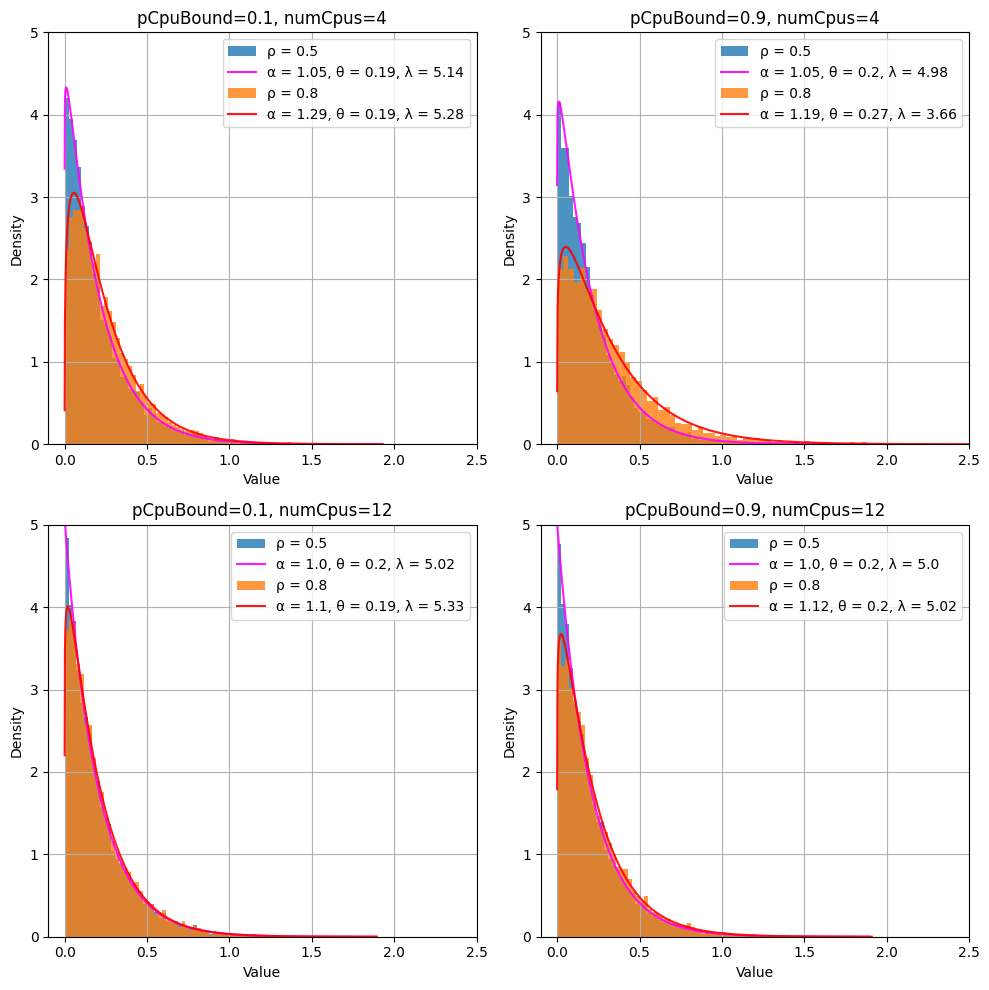

In [78]:
from scipy.stats import gamma

# Assuming filtered_array, filtered_dict, and getMeasurement are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):

    for rhoNum, elementRho in enumerate(element):

        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]

        measurement = elementRho["measurement"]
        
        # Fit Gamma distribution to the data
        shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma

        print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
        # Plot histogram
        ax, measurementString = getMeasurement(axs, measurement)
        ax.hist(values, bins=80, density=True, alpha=0.8, label=f'{rhoStrings[rhoNum]}',color=colors1[rhoNum])
        
        # Plot fitted Gamma distribution
        x = np.linspace(min(values), max(values), 1000)
        pdf = gamma.pdf(x, shape, loc=loc, scale=scale)
        
        lambd = 1/scale
        shape = round(shape, 2)
        lambd = round(lambd, 2)
        scale = round(scale, 2)
        ax.plot(x, pdf, '-', label=f'α = {shape}, θ = {scale}, λ = {lambd}',alpha=0.9,color=colors2[rhoNum])
        
    # Set labels and title
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_xlim(-0.1,2.5)
    ax.set_ylim(0,5)
    ax.set_title(measurementString)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

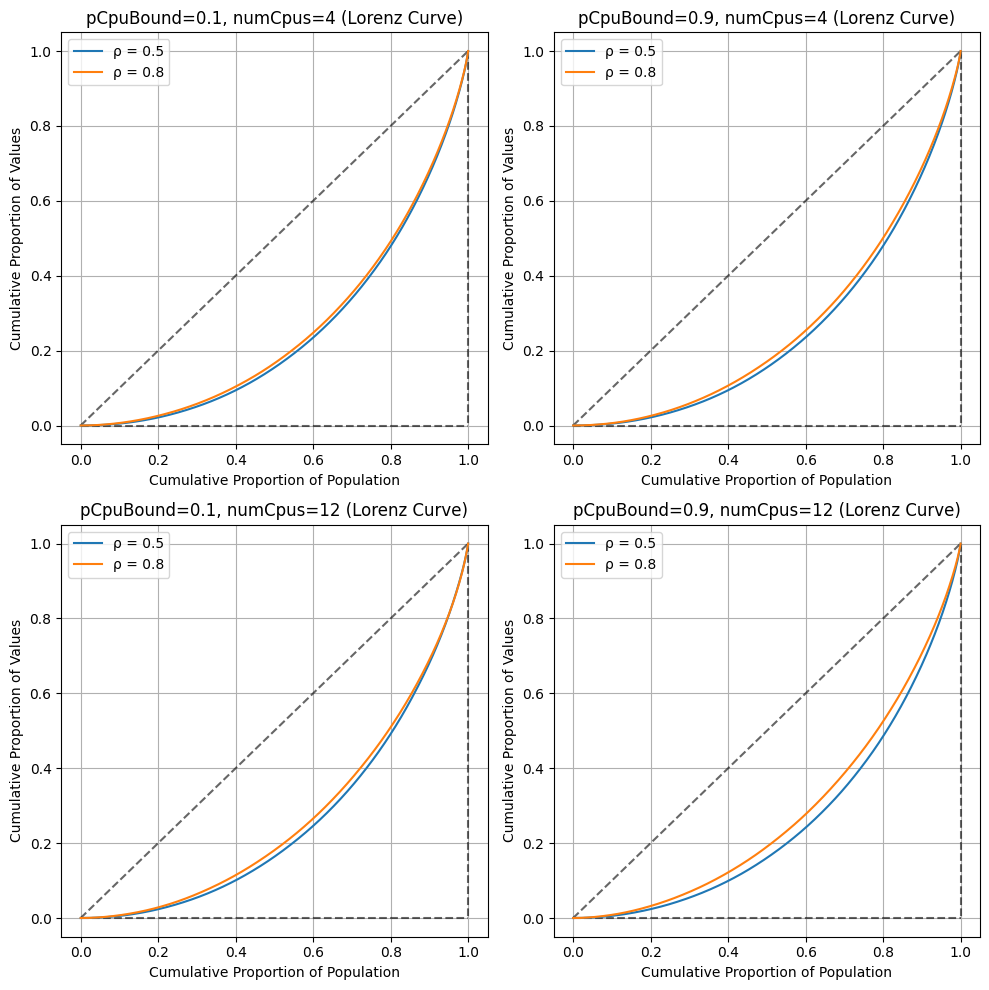

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Assuming filtered_array, filtered_dict, and getMeasurement are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

def lorenz_curve(values):
    """Compute the Lorenz curve for a given array of values."""
    values = np.sort(values)  # Sort values in ascending order
    n = len(values)
    cumulative_values = np.cumsum(values)  # Cumulative sum of values
    cumulative_proportion = cumulative_values / cumulative_values[-1]  # Normalize to [0, 1]
    population_proportion = np.arange(1, n + 1) / n  # Cumulative proportion of population
    return population_proportion, cumulative_proportion

for i, element in enumerate(filtered_array_rho):

    ax, measurementString = getMeasurement(axs, measurement)
    
    ax.plot([0, 1], [0, 1], 'k--',alpha=0.6)
    ax.plot([1, 1], [1, 0], 'k--',alpha=0.6)
    ax.plot([0, 1], [0, 0], 'k--',alpha=0.6)

    for rhoNum, elementRho in enumerate(element):


        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        
        # Compute the Lorenz curve
        population_proportion, cumulative_proportion = lorenz_curve(values)
        # Plot the Lorenz curve
        ax.plot(population_proportion, cumulative_proportion, label=rhoStrings[rhoNum], color=colors1[rhoNum])
        
    # Set labels and title
    ax.set_xlabel('Cumulative Proportion of Population')
    ax.set_ylabel('Cumulative Proportion of Values')
    ax.set_title(f'{measurementString} (Lorenz Curve)')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

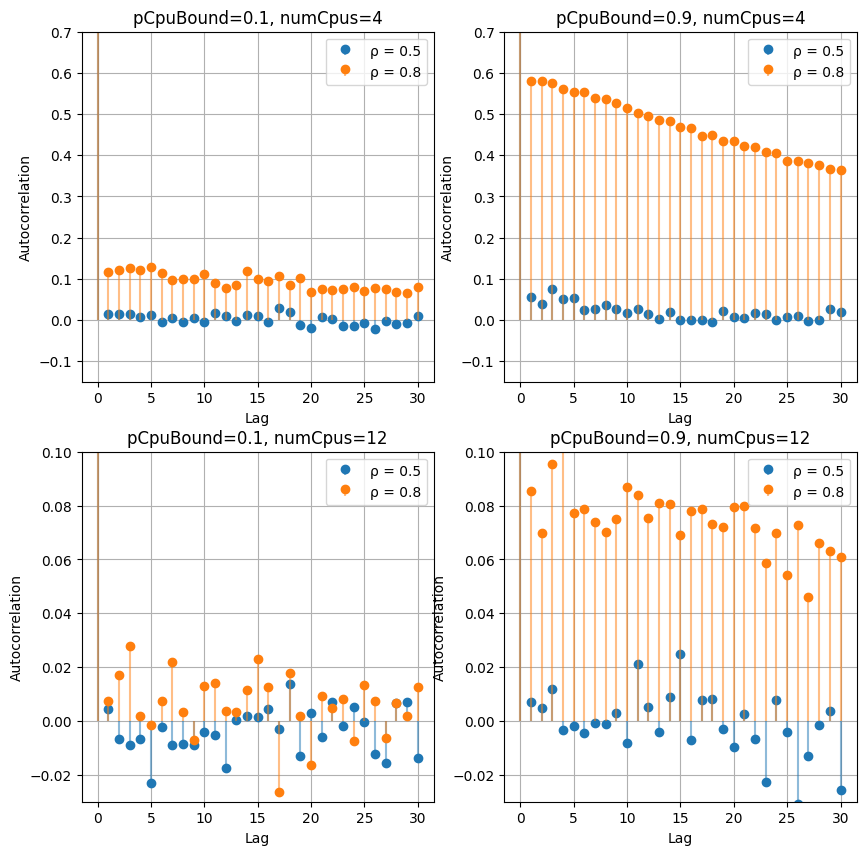

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Assuming filtered_array_rho, getMeasurement, and statistic are defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

lags = 30  # Number of lags to consider

for i, element in enumerate(filtered_array_rho):
    combValues = []
    measurement=''
    rhoVals=['','']

    for rhoNum, elementRho in enumerate(element): 
        # print(elementRho.keys())
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
    
        # Compute autocorrelation
        autocorr_values = acf(values[:len(values)//1], nlags=lags, fft=True)
    
        # print(f"Autocorrelation values for {measurement}: {autocorr_values}")

        combValues.append(autocorr_values)

        ax, measurementString = getMeasurement(axs, measurement)

    # Get the correct subplot axis
    ax, measurementString = getMeasurement(axs, measurement)
    
    # Create an x-axis for the stem plot
    x_vals = np.arange(len(autocorr_values))  # Lag indices

    top0=max(combValues[0][1:lags])
    top1=max(combValues[1][1:lags])
    top=1.2*max(top0,top1)

    for idx, autocorr_vals in (list(enumerate(combValues))):
        colorStem=f"{colors1[idx]}ff"
        colorLine=f"{colors1[idx]}80"
        ax.stem(x_vals, autocorr_vals, label=f'{rhoStrings[idx]}', linefmt=colorLine, markerfmt=colorStem, basefmt=" ")

    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    # ax.set_ylim(-top/10,top)

    if '$numCpus=4' in measurement:
        ax.set_ylim(-0.15,0.7)
    else:
        ax.set_ylim(-0.03,0.1)
    ax.set_title(measurementString)
    ax.legend()
    ax.grid(True)

# plt.tight_layout()
plt.show()


In [81]:
import copy
filtered_array_rho_iid=[]


for i, element in enumerate(filtered_array_rho):

    filtered_array_rho_iid.append([{},{}])

    for rhoNum, elementRho in enumerate(element):

        values = elementRho['modules']["Computer.scheduler"][statistic]["values"].copy()

        print(len(values))

        values = makeValuesIndependent(values)

        filtered_array_rho_iid[i][rhoNum] = copy.deepcopy(elementRho)

        filtered_array_rho_iid[i][rhoNum]['modules']["Computer.scheduler"][statistic]["values"]=values.copy()


9326
At the end k=1, number of samples is: 4678
9089
At the end k=4, number of samples is: 564
8745
At the end k=0, number of samples is: 8745
8283
At the end k=1, number of samples is: 4063
8874
At the end k=2, number of samples is: 2245
8073
At the end k=7, number of samples is: 75
8529
At the end k=0, number of samples is: 8529
8297
At the end k=4, number of samples is: 501


In [82]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import bootstrap


# for i, element in enumerate(filtered_array_rho_iid):

#     for rhoNum, elementRho in enumerate(element):
#         values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        
#         # Bootstrap analysis
#         data = (values,)
        
#         # Bootstrap for mean
#         res_mean = bootstrap(data, np.mean, n_resamples=999, confidence_level=0.95)
#         mean_low, mean_high = res_mean.confidence_interval
#         mean_value = np.mean(values)
        
#         # Bootstrap for std dev
#         res_dev = bootstrap(data, np.std, n_resamples=999, confidence_level=0.95)
#         dev_low, dev_high = res_dev.confidence_interval
#         std_value = np.std(values)
        
#         # Print confidence intervals
#         print(f"Confidence interval for mean: {mean_low} to {mean_high}")
#         print(f"Confidence interval for std dev: {dev_low} to {dev_high}")
        
#         # Histogram plot
#         bins = 25
#         fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        
#         ax[0].hist(res_mean.bootstrap_distribution, bins=bins)
#         ax[0].set_title('Mean')
#         ax[0].set_xlabel('Value')
#         ax[0].set_ylabel('Frequency')
        
#         ax[1].hist(res_dev.bootstrap_distribution, bins=bins)
#         ax[1].set_title('Standard Deviation')
#         ax[1].set_xlabel('Value')
#         ax[1].set_ylabel('Frequency')
        
#         plt.tight_layout()
#         plt.show()
        
#         # Store results in a table-like format
#         print("\nResults Table:")
#         print(f"{'Metric':<20} {'Mean':<15} {'95% CI Low':<15} {'95% CI High'}")
#         print(f"{'Mean':<20} {mean_value:<15.4f} {mean_low:<15.4f} {mean_high:<15.4f}")
#         print(f"{'Standard Deviation':<20} {std_value:<15.4f} {dev_low:<15.4f} {dev_high:<15.4f}\n")


In [83]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap

# Initialize a dictionary to store results
data_dict = {}

for i, element in enumerate(filtered_array_rho_iid):
    for rhoNum, elementRho in enumerate(element):
        try:
            values = np.array(elementRho['modules']["Computer.scheduler"][statistic]["values"])
            measurement = elementRho['measurement']

            # Ensure values is a NumPy array
            if values.size == 0:
                continue  # Skip empty values to avoid errors

            # Bootstrap analysis
            data = (values,)

            # Bootstrap for mean
            res_mean = bootstrap(data, np.mean, n_resamples=999, confidence_level=0.95, vectorized=True)
            mean_low, mean_high = res_mean.confidence_interval
            mean_value = np.mean(values)

            # Bootstrap for std dev
            res_dev = bootstrap(data, np.std, n_resamples=999, confidence_level=0.95, vectorized=True)
            dev_low, dev_high = res_dev.confidence_interval
            std_value = np.std(values)

            ax, measurementString = getMeasurement(axs, measurement)

            rhoString = rhoStrings[rhoNum]


            # Organize data into dictionary format
            if measurementString not in data_dict:
                data_dict[measurementString] = {}
            if rhoString not in data_dict[measurementString]:
                data_dict[measurementString][rhoString] = {}

            data_dict[measurementString][rhoString] = {
                ('Mean', 'Value'): mean_value,
                ('Mean', '95% CI Low'): mean_low,
                ('Mean', '95% CI High'): mean_high,
                ('Std Dev', 'Value'): std_value,
                ('Std Dev', '95% CI Low'): dev_low,
                ('Std Dev', '95% CI High'): dev_high
            }

        except KeyError as e:
            print(f"KeyError encountered: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

# Convert the nested dictionary into a properly structured DataFrame
df_results = pd.DataFrame.from_dict(
    {(measurement, rho): values for measurement, rhos in data_dict.items() for rho, values in rhos.items()},
    orient='index'
)

# Set the column names as MultiIndex
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns, names=['Metric', 'Statistic'])

# **Transpose the DataFrame to invert rows and columns**
df_results = df_results.T

# Display the DataFrame
display(df_results)


pCpuBound=0.1, numCpus=4            \
                                     ρ = 0.5   ρ = 0.8   
Metric  Statistic                                        
Mean    Value                       0.202763  0.245797   
        95% CI Low                  0.197415  0.230200   
        95% CI High                 0.209074  0.263482   
Std Dev Value                       0.198341  0.206086   
        95% CI Low                  0.191384  0.189657   
        95% CI High                 0.206320  0.229719   

                    pCpuBound=0.1, numCpus=12            \
                                      ρ = 0.5   ρ = 0.8   
Metric  Statistic                                         
Mean    Value                        0.198633  0.209230   
        95% CI Low                   0.194649  0.203012   
        95% CI High                  0.202851  0.215513   
Std Dev Value                        0.197425  0.200682   
        95% CI Low                   0.191928  0.192403   
        95% CI High                  0.203428  0.209044   

                    pCpuBound=0.9, numCpus=4            \
                                     ρ = 0.5   ρ = 0.8   
Metric  Statistic                                        
Mean    Value                       0.209255  0.344960   
        95% CI Low                  0.201424  0.290819   
        95% CI High                 0.218285  0.423067   
Std Dev Value                       0.199023  0.307241   
        95% CI Low                  0.189131  0.227057   
        95% CI High                 0.213089  0.469909   

                    pCpuBound=0.9, numCpus=12            
                                      ρ = 0.5   ρ = 0.8  
Metric  Statistic                                        
Mean    Value                        0.199737  0.220137  
        95% CI Low                   0.195243  0.204592  
        95% CI High                  0.203686  0.239397  
Std Dev Value                        0.197837  0.185459  
        95% CI Low                   0.192575  0.171398  
        95% CI High                  0.204448  0.200871

In [84]:
# from scipy.stats import gamma, probplot
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming filtered_array_rho, filtered_dict, getMeasurement, rhoStrings, and colors1 are already defined

# # Create subplots
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# for i, element in enumerate(filtered_array_rho):
    
#     ax, measurementString = getMeasurement(axs, measurement)
    
#     for rhoNum, elementRho in enumerate([element[0]]):
#         values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
#         measurement = elementRho["measurement"]
        
#         # Fit Gamma distribution to the data
#         shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma
        
#         print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
#         # Generate Q-Q plot
#         probplot(values, dist=gamma, sparams=(shape, loc, scale), plot=ax)
#         for line in ax.get_lines():
#             line.set_markersize(3)  # Set dot size
        
#     # Customize first set of dots (blue with purple)
#     ax.get_lines()[0].set_color(colors1[0])
#     ax.get_lines()[0].set_alpha(1)
#     ax.get_lines()[1].set_alpha(0.8)
#     # ax.get_lines()[0].set_markerfacecolor(colors1[1])
    
#     # Customize second set of dots (orange) and line (red)
#     # ax.get_lines()[2].set_color(colors1[1])
#     # ax.get_lines()[2].set_alpha(0.6)
#     # ax.get_lines()[3].set_alpha(0.3)

#     # ax.get_lines()[1].set_linewidth(2)
#     # Customize plot
#     ax.set_title(f'Q-Q Plot: {measurementString}')
#     ax.grid(True)
#     ax.legend([f'{rhoStrings[rhoNum]}'], loc='best')

# plt.tight_layout()
# plt.show()


Shape: 1.049555956943487, loc: 0, scale: 0.19447029498874763
Shape: 1.2942847364566763, loc: 0, scale: 0.18954657599082655
Shape: 0.9967915685203594, loc: 0, scale: 0.19927255288442475
Shape: 1.1016380201889606, loc: 0, scale: 0.18778366391675305
Shape: 1.0525664871550118, loc: 0, scale: 0.20094401211302607
Shape: 1.1906701762812792, loc: 0, scale: 0.2731338038940899
Shape: 0.9993261460138366, loc: 0, scale: 0.19987181547718846
Shape: 1.117786022924543, loc: 0, scale: 0.19917216360869291


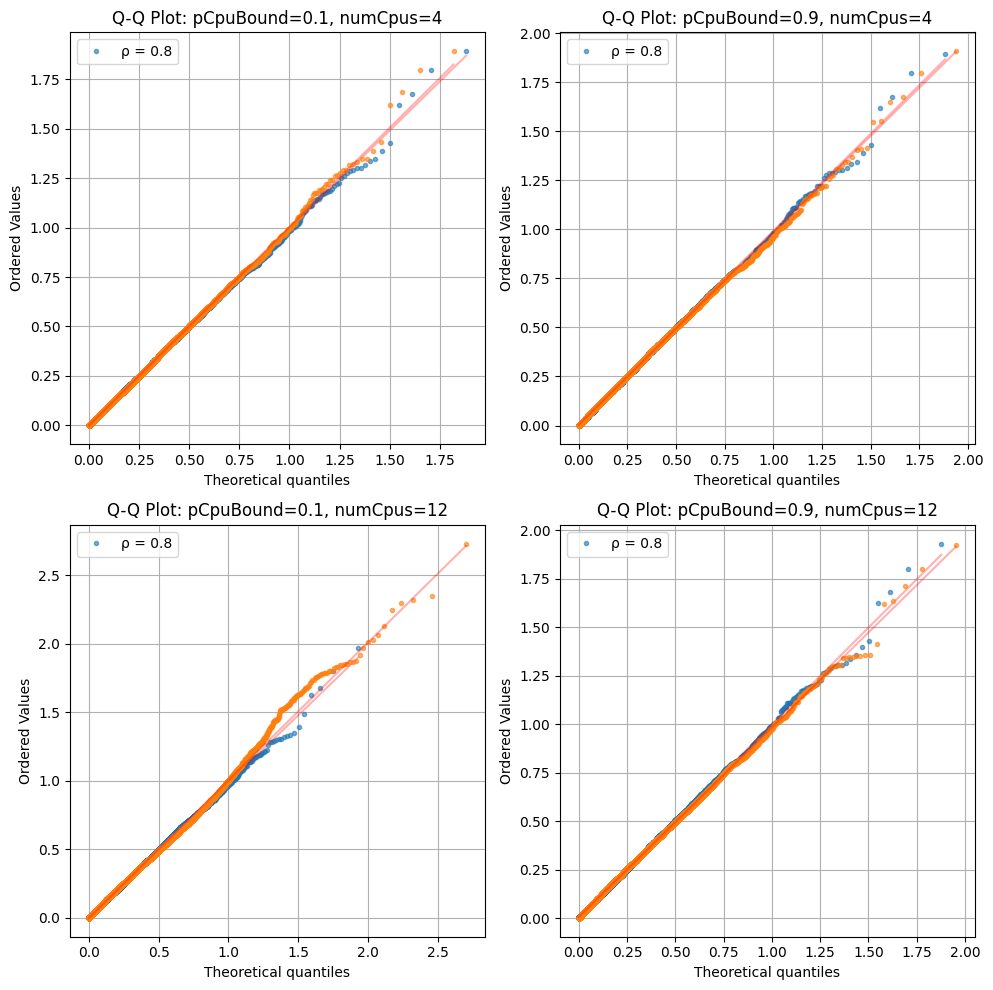

In [85]:
from scipy.stats import gamma, probplot
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_array_rho, filtered_dict, getMeasurement, rhoStrings, and colors1 are already defined

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, element in enumerate(filtered_array_rho):
    
    ax, measurementString = getMeasurement(axs, measurement)
    
    for rhoNum, elementRho in enumerate(element):
        values = elementRho['modules']["Computer.scheduler"][statistic]["values"]
        measurement = elementRho["measurement"]
        
        # Fit Gamma distribution to the data
        shape, loc, scale = gamma.fit(values, floc=0)  # Force loc=0 for Gamma
        
        print(f"Shape: {shape}, loc: {loc}, scale: {scale}")
        
        # Generate Q-Q plot
        probplot(values, dist=gamma, sparams=(shape, loc, scale), plot=ax)
        for line in ax.get_lines():
            line.set_markersize(3)  # Set dot size
        
    # Customize first set of dots (blue with purple)
    ax.get_lines()[0].set_color(colors1[0])
    ax.get_lines()[0].set_alpha(0.6)
    ax.get_lines()[1].set_alpha(0.3)
    # ax.get_lines()[0].set_markerfacecolor(colors1[1])
    
    # Customize second set of dots (orange) and line (red)
    ax.get_lines()[2].set_color(colors1[1])
    ax.get_lines()[2].set_alpha(0.6)
    ax.get_lines()[3].set_alpha(0.3)

    # ax.get_lines()[1].set_linewidth(2)
    # Customize plot
    ax.set_title(f'Q-Q Plot: {measurementString}')
    ax.grid(True)
    ax.legend([f'{rhoStrings[rhoNum]}'], loc='best')

plt.tight_layout()
plt.show()


In [86]:
# values = filtered_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

# p=1/2**0

# new_values=[]

# for value in values:
#     rand=np.random.uniform()
#     if rand<p:
#         new_values.append(value)

# values=new_values


# avg, std = avg_and_std(values)

# # Calculate autocorrelation
# autocorr_values = autocorrelation(values)

# stop=100
# lags=range(0,stop)

# plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
# plt.title(f"Sample Autocorrelation")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
# # plt.ylim(top=0.12)


# # Add horizontal lines at ±1.96/sqrt(n)
# n = len(values)  # Sample size
# confidence_interval = 1.96 / np.sqrt(n)
# plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
# plt.axhline(y=-confidence_interval, color='r', linestyle='--')

# plt.grid(True)
# plt.legend()
# plt.show()


# # #Ljung–Box test

# # h=30

# # Q=0
# # n=len(values)

# # for i in range(1,h):
# #     Q+=n*(n+2)*(autocorr_values[i]**2)/(n-i)

# # print(f"h: {h}, Q: {Q}")

# # # Calculate number of values outside confidence interval

# # outside=0


# # test_values=autocorr_values[1:]

# # for value in test_values:
# #     if value > confidence_interval or value < -confidence_interval:
# #         outside+=1

# # print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# # # Calculate number of values outside confidence interval near

# # outside=0
# # stop=100

# # test_values=autocorr_values[1:stop]

# # for value in test_values:
# #     if value > confidence_interval or value < -confidence_interval:
# #         outside+=1

# # print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# # print(f"Now the number of samples is: {len(values)}")

In [87]:
# testToUse="""$pCpuBound=0.9, $rho=0.8, $meanProcessDuration=500ms, $numCpus=12, $generationType="exponential", $durationType="exponential", $isFCFS=true"""


In [88]:
# values = filtered_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

# p=1/2**0

# new_values=[]

# for value in values:
#     rand=np.random.uniform()
#     if rand<p:
#         new_values.append(value)

# values=new_values


# avg, std = avg_and_std(values)

# # Calculate autocorrelation
# autocorr_values = autocorrelation(values)

# stop=100
# lags=range(0,stop)

# plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
# plt.title(f"Sample Autocorrelation")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
# # plt.ylim(top=0.12)


# # Add horizontal lines at ±1.96/sqrt(n)
# n = len(values)  # Sample size
# confidence_interval = 1.96 / np.sqrt(n)
# plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
# plt.axhline(y=-confidence_interval, color='r', linestyle='--')

# plt.grid(True)
# plt.legend()
# plt.show()


# # #Ljung–Box test

# # h=30

# # Q=0
# # n=len(values)

# # for i in range(1,h):
# #     Q+=n*(n+2)*(autocorr_values[i]**2)/(n-i)

# # print(f"h: {h}, Q: {Q}")

# # # Calculate number of values outside confidence interval

# # outside=0


# # test_values=autocorr_values[1:]

# # for value in test_values:
# #     if value > confidence_interval or value < -confidence_interval:
# #         outside+=1

# # print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# # # Calculate number of values outside confidence interval near

# # outside=0
# # stop=100

# # test_values=autocorr_values[1:stop]

# # for value in test_values:
# #     if value > confidence_interval or value < -confidence_interval:
# #         outside+=1

# # print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# # print(f"Now the number of samples is: {len(values)}")

In [89]:
# # testToUse=names[1]

# values = good_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

# values= makeValuesIndependent(values)

# avg, std = avg_and_std(values)

# # Calculate autocorrelation
# autocorr_values = autocorrelation(values)

# stop=60
# lags=range(0,stop)

# plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
# plt.title(f"Sample Autocorrelation")
# plt.xlabel("Lag")
# plt.ylabel("Autocorrelation")
# plt.ylim(top=max(autocorr_values[1:]*1.2))


# # plt.ylim(top=max(autocorr_values[1:]*1.2))
# # plt.ylim(top=0.12)


# # Add horizontal lines at ±1.96/sqrt(n)
# n = len(values)  # Sample size
# assert n > 500
# confidence_interval = 1.96 / np.sqrt(n)
# plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
# plt.axhline(y=-confidence_interval, color='r', linestyle='--')

# plt.grid(True)
# plt.legend()
# plt.show()


In [90]:
# from scipy.stats import expon

# #histogram of values
# bins=100
# plt.hist(values,bins=bins,density=True)

# #plot also a exponential curve
# # Fit an exponential distribution to the data
# loc, scale = expon.fit(values,floc=0)
# print(f"Fitted with mean {scale}")

# # Generate the x values for the exponential curve
# x = np.linspace(min(values), max(values), bins)

# # Plot the exponential curve
# # plt.plot(x, 2*len(values)/bins*expon.pdf(x, loc, scale), 'r-', lw=2, label='Exponential fit', alpha=0.8)
# plt.plot(x, expon.pdf(x, 0, scale), 'r-', lw=2, label='Exponential fit', alpha=0.6)
# plt.legend()
# # plt.xlim(-0.05,1.5)
# plt.show()


In [91]:
# #qq plot
# import scipy.stats as stats

# # Generate a QQ plot
# # fig, ax = plt.subplots()
# res=stats.probplot(values, dist="expon", sparams=(loc, scale))

In [92]:
# #plot 1 quantile for each 10 available

# step=1
# # step=len(values)//20

# # Generate a QQ plot with step
# fig, ax = plt.subplots()
# res = stats.probplot(values[::step], dist="expon", sparams=(loc, scale), plot=ax)
# ax.grid(True)
# plt.show()

In [93]:
# from scipy.stats import bootstrap

In [94]:
# def stdDev(values):
#     return np.std(values)
# def mean(values):
#     return np.mean(values)

In [95]:
# data = (values,)  # samples must be in a sequence

# # Bootstrap for mean
# res_mean = bootstrap(data, mean, n_resamples=999, confidence_level=0.95)
# low, high = res_mean.confidence_interval
# print(f"Confidence interval for mean: {low} to {high}")
# bins=25
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
# ax[0].hist(res_mean.bootstrap_distribution, bins=bins)
# ax[0].set_title('Mean')
# ax[0].set_xlabel('Standard Deviation')
# ax[0].set_ylabel('Frequency')

# # Bootstrap for std dev
# res_dev = bootstrap(data, stdDev, n_resamples=999, confidence_level=0.95)
# low, high = res_dev.confidence_interval
# print(f"Confidence interval for mean: {low} to {high}")

# ax[1].hist(res_dev.bootstrap_distribution, bins=bins)
# ax[1].set_title('Std Dev')
# ax[1].set_xlabel('Mean')
# ax[1].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()



In [96]:
# sampMean, sampStd = avg_and_std(values)

# confLef=sampMean-1.96*sampStd/np.sqrt(len(values))
# confRig=sampMean+1.96*sampStd/np.sqrt(len(values))

# print(f"Confidence interval: {confLef} to {confRig}")

In [97]:
# import numpy as np

# from scipy import stats

# import matplotlib.pyplot as plt

# nsample = 100

# rng = np.random.default_rng()